In [1]:
%pylab inline

from PyTools import err, binner, nbins, binned_stat
from scipy.optimize import leastsq
from string import join
from scipy.ndimage.filters import gaussian_filter
import paper_style, os

Populating the interactive namespace from numpy and matplotlib


In [2]:
write_tables_for_fig4 = False

def put_FITS_names(table):
    descr = table.dtype.descr
    for i in xrange(3): descr.pop(0)
    descr = [("input_file", "|S25")] + descr

    new_table = zeros(table.shape[0], dtype=descr)
    new_table["input_file"] = ["spSpec-{0:05d}-{1:04d}-{2:03d}.fit".format(r["mjd"], r["plate"], r["fiberID"])
                               for r in table]
    for f in new_table.dtype.names[1:]:
        new_table[f] = table[f]
    
    return new_table

par_lbs = [r"$M_\star$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
           r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$"]

if "paper_style" in dir():
    mnorm = 1e9
    od = os.path.expandvars("$HOME/Documents/Publications/photofit_near_paper/")
    par_lbs = [r"$\log{M_\star/M\odot}$", r"$\left<\log{t_\star}\right>_M$", r"$\left<\log{t_\star}\right>_L$",
               r"$\left<\log{Z_\star/Z\odot}\right>_M$", r"$\left<\log{Z_\star/Z\odot}\right>_L$", r"$A_V$",
               r"$A_V$", r"$z$"]
    res_lbs = [r"$\Delta\log{M_\star}$", r"$\Delta\left<\log{t_\star}\right>_M$",
               r"$\Delta\left<\log{t_\star}\right>_L$", r"$\Delta\left<\log{Z_\star}\right>_M$",
               r"$\Delta\left<\log{Z_\star}\right>_L$", r"$\Delta A_V$"]
    hatching = "/"*15
    gray = "0.3"
    ssag_cl = "0.2"
    sdss_cl = "#F6C141"
    sdss_sg = [sdss_cl, "#E8601C"]
    jpas_cl = "#90C987"
    jpas_sg = [jpas_cl, "#4EB265"]
    spec_cl = "#7BAFDE"
    spec_sg = [spec_cl, "#1965B0"]
    map_col = cm.Blues
else:
    mnorm = 1e8
    od = "img/"
    par_lbs = ["Mass (log/M$\odot$)", "Age (log/yr)", "Age (log/yr)", "Metallicity (log/Z$\odot$)",
               "Metallicity (log/Z$\odot$)", "Dust Extinction (mag)", "Redshift"]

In [3]:
#READ TABLES

emission_detections = loadtxt("../inputs/real_deal/jpas_residual_emission.txt", dtype=str)
Lfrac = put_FITS_names(genfromtxt("data/RealDeal/lumfrac.txt", dtype=None, names=True))
SN = genfromtxt("data/RealDeal/snr.txt", dtype=None, names=True)
Cind = put_FITS_names(genfromtxt("data/RealDeal/conIndex_test.txt", dtype=None, names=True))
u_lib, g_lib, r_lib, i_lib, z_lib = loadtxt("../inputs/tta_cb13/ssag/set_catalog.txt", usecols=range(1,1+5), unpack=True)
catalog = genfromtxt("data/RealDeal/catalog.txt", dtype=None, names=True)
gal2005 = genfromtxt("data/RealDeal/gal2005.txt", dtype=None, names=True)
galtab2 = array([[ 8.91, -0.60, -1.11, -0.00, 9.06, 8.80,  9.46],
                 [ 9.11, -0.61, -1.07, -0.00, 9.09, 8.81,  9.48],
                 [ 9.31, -0.65, -1.10, -0.05, 9.11, 8.85,  9.44],
                 [ 9.51, -0.61, -1.03, -0.01, 9.17, 8.89,  9.49],
                 [ 9.72, -0.52, -0.97,  0.05, 9.23, 8.94,  9.57],
                 [ 9.91, -0.41, -0.90,  0.09, 9.32, 9.00,  9.71],
                 [10.11, -0.23, -0.80,  0.14, 9.46, 9.09,  9.85],
                 [10.31, -0.11, -0.65,  0.17, 9.61, 9.23,  9.93],
                 [10.51, -0.01, -0.41,  0.20, 9.73, 9.34,  9.98],
                 [10.72,  0.04, -0.24,  0.22, 9.82, 9.48, 10.03],
                 [10.91,  0.07, -0.14,  0.24, 9.87, 9.60, 10.06],
                 [11.11,  0.10, -0.09,  0.25, 9.90, 9.67, 10.08],
                 [11.31,  0.12, -0.06,  0.26, 9.92, 9.72, 10.09],
                 [11.51,  0.13, -0.04,  0.28, 9.94, 9.75, 10.11],
                 [11.72,  0.14, -0.03,  0.29, 9.95, 9.76, 10.12],
                 [11.91,  0.15, -0.03,  0.30, 9.96, 9.77, 10.12]])

spec_ne = genfromtxt(os.path.expandvars("$master/inputs/real_deal/outs/spec/")+"dynbas_output.log", dtype=None,
                     names=True)
spec_ne["input_file"] = array(["spSpec"+name.lstrip("dynbasfit_processed_SPEC_").replace(".log", ".fit")
                               for name in spec_ne["input_file"]])
spec_ne["M_mod"] = log10(spec_ne["M_mod"])

jpas_ne = genfromtxt(os.path.expandvars("$master/inputs/real_deal/outs/nem_jpas/")+"dynbas_output.log",
                     dtype=None, names=True)
jpas_ne["input_file"] = array(["spSpec"+name.lstrip("dynbasfit_processed_nem_JPAS_").replace(".log", ".fit")
                               for name in jpas_ne["input_file"]])
jpas_ne["M_mod"] = log10(jpas_ne["M_mod"])
                                                           
parr = array([-1.69252953, -0.4964394,   9.35303768])
pard = array([ 0.04363491, -0.23994185,  9.56363449])
par0 = array([ 0.32472905, -0.39032184,  9.70852055])
x = linspace(8.0, 10.2)
y = linspace(-0.7, 0.4)

In [4]:
NR = 20

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["input_file"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["umag"]-ssag_tta["rmag"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kw = [field.rstrip("_mod") for field in fields]

jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

jpas_res = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)

In [5]:
#COMMON MASKS
in_spec_ne = array([galaxy in spec_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_jpas_ne = array([galaxy in jpas_ne["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
in_gal2005 = array([galaxy in gal2005["input_file"] for galaxy in catalog["input_file"]], dtype=bool)
g05_in_sam = array([galaxy in spec_ne["input_file"] for galaxy in gal2005["input_file"]], dtype=bool)
sam_in_g05 = array([galaxy in gal2005["input_file"] for galaxy in spec_ne["input_file"]], dtype=bool)
nem_detect = ~array([galaxy in emission_detections for galaxy in spec_ne["input_file"]], dtype=bool)

col = (catalog["u_mag"] - catalog["r_mag"])[in_spec_ne]
snr = SN[in_spec_ne]

#SAMPLE DEFINITION MASKS
# mask for g05 subsamples
SF_hSNR_g05_mask = (sam_in_g05)&(col< 2.22)&(snr["snr_wall"]>15.0)
SF_hSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr["snr_wall"]>15.0)
Pa_hSNR_g05_mask = (sam_in_g05)&(col>=2.22)&(snr["snr_wall"]>15.0)
# mask for cat subsamples
SF_lSNR_m16_mask = (~sam_in_g05)&(col< 2.22)&(snr["snr_wall"]<=15.0)
Pa_lSNR_m16_mask = (~sam_in_g05)&(col>=2.22)&(snr["snr_wall"]<=15.0)

In [6]:
print "SF_hSNR_g05:", SF_hSNR_g05_mask.sum()
print "SF_hSNR_m16:", SF_hSNR_m16_mask.sum()
print "Pa_hSNR_g05:", Pa_hSNR_g05_mask.sum()
print "SF_lSNR_m16:", SF_lSNR_m16_mask.sum()
print "Pa_lSNR_m16:", Pa_lSNR_m16_mask.sum()
print
print "Total      :", SF_hSNR_g05_mask.sum()+SF_hSNR_m16_mask.sum()+Pa_hSNR_g05_mask.sum()+SF_lSNR_m16_mask.sum()+\
                      Pa_lSNR_m16_mask.sum()

SF_hSNR_g05: 3575
SF_hSNR_m16: 1719
Pa_hSNR_g05: 5887
SF_lSNR_m16: 1608
Pa_lSNR_m16: 144

Total      : 12933


In [7]:
#COMMON QUANTITIES

cat = catalog[in_spec_ne]
lfr = Lfrac[in_spec_ne]
con = (Cind["petroR90_r"][in_spec_ne]/Cind["petroR50_r"][in_spec_ne])
rat = 3./Cind["petroR90_r"][in_spec_ne]
col = cat["u_mag"] - cat["r_mag"]

sfgal = col<2.22
pagal = col>=2.22

/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/home/mejia/Programs/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


In [8]:
print "tables match?", all(spec_ne["input_file"]==cat["input_file"])&all(cat["input_file"]==lfr["input_file"])&\
                       all(cat["input_file"]==Cind["input_file"][in_spec_ne])

tables match? True


In [9]:
if write_tables_for_fig4:
    mask = nem_detect&(snr["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)
    savetxt("data/PhotoNearAnalysis/ur_color.txt", col[mask])
    for i, field in enumerate(spec_ne.dtype.names):
        if i in [2,3,4,5,6,7]:
            savetxt("data/PhotoNearAnalysis/JPAS_{0}.txt".format(field), jpas_ne[mask][field])
            savetxt("data/PhotoNearAnalysis/SPEC_{0}.txt".format(field), spec_ne[mask][field])
    print "tables written"

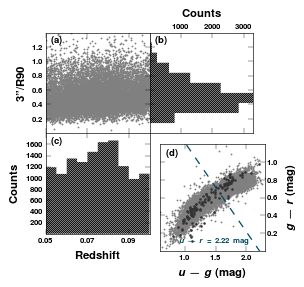

In [10]:
fig = figure(figsize=(2.5, 2.5))

gs1 = matplotlib.gridspec.GridSpec(2, 2, hspace=0, wspace=0, left=0, top=1)
ax00 = fig.add_subplot(gs1[0, 0], xticklabels=[])
ax01 = fig.add_subplot(gs1[0, 1])
ax10 = fig.add_subplot(gs1[1, 0])

ax01.tick_params(labelleft=False, labelbottom=False, labeltop=True)
ax01.xaxis.set_label_position("top")

gs2 = matplotlib.gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1, left=0, top=1, right=0.95, bottom=0.05)
ax11 = fig.add_subplot(gs2[1, 1])

ax11.tick_params(labelleft=False, labelright=True)
ax11.yaxis.set_label_position("right")

axs = array([[ax00, ax01], [ax10, ax11]])
# ---------------------------------------------------------------------------
axs[0, 0].text(0.05, 0.90, r"\bf (a)", fontsize="small", ha="left", transform=axs[0,0].transAxes)
axs[0, 0].set_xticks(arange(0.05, 0.11, 0.02))
axs[0, 0].set_xlim(0.05, 0.1)
axs[0, 0].set_ylim(0.00, 1.4)
axs[0, 0].set_ylabel(r'\bf 3"/R90')
axs[0, 0].scatter(cat["redshift"], rat, lw=0, c="0.5", s=2)
# ---------------------------------------------------------------------------
axs[0, 1].text(0.05, 0.90, r"\bf (b)", fontsize="small", ha="left", transform=axs[0,1].transAxes)
axs[0, 1].set_xticks([0, 1000, 2000, 3000, 3500])
rg = axs[0, 1].set_ylim(0.00, 1.4)
axs[0, 1].set_xlabel(r"\bf Counts")
axs[0, 1].hist(rat, 10, histtype="stepfilled", hatch=4*"///", lw=0, fc="none", color="0.5", range=rg,
               orientation="horizontal")
# ---------------------------------------------------------------------------
axs[1, 0].text(0.05, 0.90, r"\bf (c)", fontsize="small", ha="left", transform=axs[1,0].transAxes)
axs[1, 0].set_xticks(arange(0.05, 0.11, 0.02))
rg = axs[1, 0].set_xlim(0.05, 0.1)
axs[1, 0].set_xlabel(r'\bf Redshift')
axs[1, 0].set_ylabel(r"\bf Counts")
axs[1, 0].hist(cat["redshift"], 10, histtype="stepfilled", hatch=4*"///", lw=0, fc="none", color="0.5", range=rg)
# ---------------------------------------------------------------------------
xl, yl = array(axs[1,1].set_xlim(0.6, 2.3)), array(axs[1,1].set_ylim(0.0, 1.2))
axs[1, 1].text(0.05, 0.90, r"\bf (d)", fontsize="small", ha="left", transform=axs[1,1].transAxes)
axs[1, 1].set_xlabel(r"\bf $u-g$ (mag)")
axs[1, 1].set_ylabel(r"\bf $g-r$ (mag)")
axs[1, 1].scatter(cat["u_mag"]-cat["g_mag"], cat["g_mag"]-cat["r_mag"], lw=0, c="0.5", s=2)
axs[1, 1].scatter(u_lib-g_lib, g_lib-r_lib, lw=0, c="0.2", s=4)
axs[1, 1].plot(xl, 2.22-xl, "--", color="#004E66")
axs[1, 1].text(0.85, 0.08, r"\bf $u-r=2.22\,$mag", ha="right", fontsize="x-small", color="#004E66",
               transform=axs[1,1].transAxes)
# ---------------------------------------------------------------------------

for ax in axs.ravel():
    if not ax.is_first_col():
        ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(ax.get_yticks()[1:-1])

savefig("{}sample_chars".format(od))

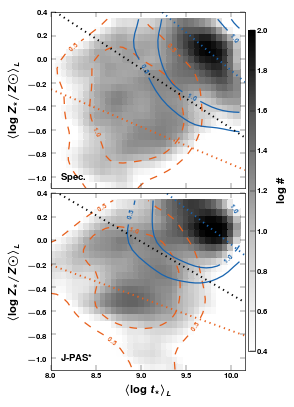

In [11]:
def deg(t, m, p0):
    t0, Z0 = p0
    return m*array(t) + (Z0-m*t0)

mask = nem_detect&(snr["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 35, 25
tables = spec_ne, jpas_ne
N, bins = histogram(col[mask], 3, (1.3,3.0))
slopes = [[-0.32, -0.51, -0.65], [-0.28, -0.45, -0.61]]
sl_col = ["#E8601C", "k", "#1965B0"]
labels = r"\bf Spec.", r"\bf J-PAS*"
x, y = "log_t_L_mod", "log_Z_L_mod"
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(3.0, 4.5))

ax1 = subplot2grid((20, 21), (0, 0), rowspan=10, colspan=20, ylabel=par_lbs[4], xticklabels=[], xlim=rx, ylim=ry)
ax2 = subplot2grid((20, 21), (10, 0), rowspan=10, colspan=20, xlabel=par_lbs[2], ylabel=par_lbs[4], xlim=rx, ylim=ry)
axc = subplot2grid((20, 21), (1, 20), rowspan=18)
axs = array([ax1, ax2])

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

#axs[0].text(0.9, 0.05, r"\bf G05", color="m", fontsize="small", ha="center", transform=axs[0].transAxes)
for i in xrange(axs.size):    
    axs[i].text(0.05, 0.05, labels[i], fontsize="small", ha="left", transform=axs[i].transAxes)

    H_al, xe, ye = histogram2d(tables[i][x][mask], tables[i][y][mask], bins=nbins, range=[rx,ry])
    H_al = gaussian_filter(H_al, sigma=1)
    H_al[H_al==0] = 1
    img = axs[i].pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=cm.Greys, vmin=0.4, vmax=2.0, edgecolor="face")

    H_sf, xe, ye = histogram2d(tables[i][x][sfgal&mask], tables[i][y][sfgal&mask], bins=nbins, range=[rx,ry])
    H_sf = gaussian_filter(H_sf, sigma=2)
    cont = axs[i].contour(xe[:-1], ye[:-1], log10(H_sf.T), [0.5,1,2], colors="#E8601C", linewidths=1.0, linestyles="--")
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

    H_pa, xe, ye = histogram2d(tables[i][x][pagal&mask], tables[i][y][pagal&mask], bins=nbins, range=[rx,ry])
    H_pa = gaussian_filter(H_pa, sigma=2)
    cont = axs[i].contour(xe[:-1], ye[:-1], log10(H_pa.T), [0.5,1,2], colors="#1965B0", linewidths=1.0)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

    #axs[i].plot(galtab2[:,4], galtab2[:,1], "-", color="m", lw=1.5)

    for ibin in xrange(bins.size-1):
        if ibin<bins.size-2:
            bin_mask = (col[mask]>=bins[ibin])&(col[mask]<bins[ibin+1])
        else:
            bin_mask = (col[mask]>=bins[ibin])&(col[mask]<=bins[ibin+1])
        
        
        p0 = median(tables[i][x][mask][bin_mask]), median(tables[i][y][mask][bin_mask])
        axs[i].plot(rx, deg(rx, slopes[i][ibin], p0), ":", lw=1.5, color=sl_col[ibin])
    
cb = colorbar(img, cax=axc)
cb.set_label(r"\bf $\log{\#}$")

savefig("{}{}".format(od, "lw_AMR"))

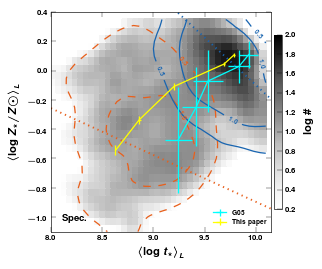

In [12]:
def deg(t, m, p0):
    t0, Z0 = p0
    return m*array(t) + (Z0-m*t0)

mask = nem_detect&(snr["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)
mmask = nem_detect&(snr["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8)&(sam_in_g05)
gmask = (nem_detect&(snr["snr_CaII"]>=5.0)&(spec_ne["log_t_L_mod"]>8)&(jpas_ne["log_t_L_mod"]>8))[sam_in_g05]
rx, ry = (8.0, 10.15), (-1.1, 0.4)
nbins = 40, 30
tables = [spec_ne]
N, bins = histogram(col[mask], 3, (1.3,3.0))
slopes = [[-0.32, -0.51, -0.65]]
sl_col = ["#E8601C", "k", "#1965B0"]
labels = [r"\bf Spec."]
x, y = "log_t_L_mod", "log_Z_L_mod"
#---------------------------------------------------------------------------------------------
fig = figure(figsize=(3.3, 3))

ax1 = subplot2grid((10, 21), (0, 0), rowspan=10, colspan=20, xlabel=par_lbs[2], ylabel=par_lbs[4], xlim=rx, ylim=ry)
axc = subplot2grid((10, 21), (1, 20), rowspan=8)
axs = array([ax1])

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

#axs[0].text(0.9, 0.05, r"\bf G05", color="m", fontsize="small", ha="center", transform=axs[0].transAxes)
for i in xrange(axs.size):    
    axs[i].text(0.05, 0.05, labels[i], fontsize="small", ha="left", transform=axs[i].transAxes)

    H_al, xe, ye = histogram2d(tables[i][x][mask], tables[i][y][mask], bins=nbins, range=[rx,ry])
    H_al = gaussian_filter(H_al, sigma=1)
    H_al[H_al==0] = 1
    img = axs[i].pcolormesh(xe[:-1], ye[:-1], log10(H_al.T), cmap=cm.Greys, vmin=0.2, vmax=2.0, edgecolor="face")

    H_sf, xe, ye = histogram2d(tables[i][x][sfgal&mask], tables[i][y][sfgal&mask], bins=nbins, range=[rx,ry])
    H_sf = gaussian_filter(H_sf, sigma=2)
    cont = axs[i].contour(xe[:-1], ye[:-1], log10(H_sf.T), [0.5,1,2], colors="#E8601C", linewidths=1.0, linestyles="--")
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

    H_pa, xe, ye = histogram2d(tables[i][x][pagal&mask], tables[i][y][pagal&mask], bins=nbins, range=[rx,ry])
    H_pa = gaussian_filter(H_pa, sigma=2)
    cont = axs[i].contour(xe[:-1], ye[:-1], log10(H_pa.T), [0.5,1,2], colors="#1965B0", linewidths=1.0)
    clabel(cont, fontsize=5, fmt=r"\bf %.1f", inline=True)

    cg05, tg05 = binner(col[mmask], gal2005[g05_in_sam][gmask][x], "median", 5, (1.3,3.0))
    cg05, tg05_p16 = binner(col[mmask], gal2005[g05_in_sam][gmask]["t_P16p0"], "median", 5, (1.3,3.0))
    cg05, tg05_p84 = binner(col[mmask], gal2005[g05_in_sam][gmask]["t_P84p0"], "median", 5, (1.3,3.0))
    tg05_rms = (tg05_p84 - tg05_p16)*0.5
    
    cg05, Zg05 = binner(col[mmask], gal2005[g05_in_sam][gmask][y], "median", 5, (1.3,3.0))
    cg05, Zg05_p16 = binner(col[mmask], gal2005[g05_in_sam][gmask]["z_P16p0"], "median", 5, (1.3,3.0))
    cg05, Zg05_p84 = binner(col[mmask], gal2005[g05_in_sam][gmask]["z_P84p0"], "median", 5, (1.3,3.0))
    Zg05_rms = (Zg05_p84 - Zg05_p16)*0.5
    
    cm16, tm16 = binner(col[mmask], spec_ne[mmask][x], "median", 5, (1.3,3.0))
    cm16, em16, tm16_p = binner(lcolor, spec_res["log_t_L"], "median", 5, (1.3,3.0), ebar=True)
    tm16 -= em16
    tm16_rms = diff(tm16_p, axis=0)[0]*0.5
    
    cm16, Zm16 = binner(col[mmask], spec_ne[mmask][y], "median", 5, (1.3,3.0))
    cm16, em16, Zm16_p = binner(lcolor, spec_res["log_Z_L"], "median", 5, (1.3,3.0), ebar=True)
    Zm16 -= em16
    Zm16_rms = diff(Zm16_p, axis=0)[0]*0.5

    axs[i].errorbar(tg05, Zg05, Zg05_rms, tg05_rms, fmt="-", mfc="none", color="cyan", ecolor="cyan", label=r"\bf G05")
    axs[i].errorbar(tm16, Zm16, Zm16_rms, tm16_rms, fmt="-", mfc="none", color="yellow", ecolor="yellow", label=r"\bf This paper")

    for ibin in xrange(bins.size-1):
        if ibin==1: continue
        if ibin<bins.size-2:
            bin_mask = (col[mask]>=bins[ibin])&(col[mask]<bins[ibin+1])
        else:
            bin_mask = (col[mask]>=bins[ibin])&(col[mask]<=bins[ibin+1])

        p0 = median(tables[i][x][mask][bin_mask]), median(tables[i][y][mask][bin_mask])
        axs[i].plot(rx, deg(rx, slopes[i][ibin], p0), ":", lw=1.5, color=sl_col[ibin])

axs[0].legend(loc=4)

cb = colorbar(img, cax=axc)
cb.set_label(r"\bf $\log{\#}$")

#savefig("{}{}".format(od, "spec_AMR"))